# KeyWordSpotting - LIVE DEMO

In [5]:
#Imports
import librosa
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import Models #Our models
import LoadAndPreprocessDataset
#.......................

categories=['yes','no','up','down','left','right','on','off','stop','go']

## 1) Audio Input
### Recording from microphone

In [47]:
sr = 16000
seconds = 10

myrec = sd.rec(int(sr*seconds), samplerate=sr, channels=1)
sd.wait()

np.save('LiveDemo/myrec.npy', myrec)

### Reading it from a numpy array

In [2]:
sr=16000
#myrec = np.load("LiveDemo/ONaudioclip.npy")
myrec = np.load("LiveDemo/myrec.npy")

### Reading it from a wav file

In [ ]:
myrec, sr = librosa.load("LiveDemo/audioclip.wav", sr=None)

### Audio Clip Informations

Sample rate =	16000 samples/s
Duration t =	10.0 s
Average intensity =	 0.0032758904


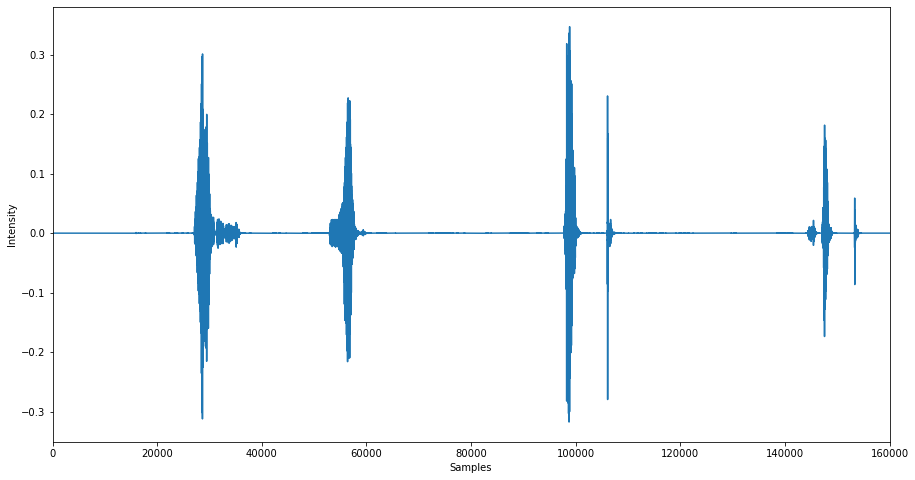

In [48]:
print("Sample rate =\t" + str(sr) + " samples/s")
print("Duration t =\t" + str(len(myrec) / sr) + " s")
print("Average intensity =\t",np.mean(np.abs(myrec)))

# Play it
play = True
if play:
    sd.play(myrec, sr)
    
# Plot
plt.figure(figsize=(15, 8))
plt.plot(myrec)
plt.xlabel("Samples")
plt.ylabel("Intensity")
plt.xlim(0, len(myrec))
plt.show()

## 2) Load Model

In [49]:
#Load Model
from tensorflow.keras.models import load_model
model_name="2020-07-23_13-11_DirectCNNBatchDrop"
model = load_model('models/'+model_name+'.h5')

## 3) ...

### Silince Filter

In [ ]:
#......

### Sliding Window
A 1 second window will slide left to right with a step of 1600 samples (100ms) in order to have 10 windows per second 



Number of windows: 91
Step: 1600
(91, 16000, 1)
(91, 1)
Window 0 Silence 2.2840499877929687e-05
Window 1 Silence 2.7544021606445314e-05
Window 2 Silence 3.216743469238281e-05
Window 3 Silence 3.7130355834960935e-05
Window 4 Silence 4.249191284179687e-05
Window 5 Silence 4.76531982421875e-05
Window 6 Silence 5.286026000976562e-05
Window 7 Silence 0.00010860061645507813
Window 8 left 0.00603178596496582
Window 9 yes 0.010697107315063476
Window 10 yes 0.011193147659301758
Window 11 yes 0.011569364547729492
Window 12 yes 0.011940643310546875
Window 13 yes 0.012028226852416992
Window 14 yes 0.01202800750732422
Window 15 yes 0.012027482986450195
Window 16 yes 0.01202654457092285
Window 17 yes 0.011971731185913086
Window 18 yes 0.006050619125366211
Window 19 up 0.0013877296447753907
Window 20 Silence 0.0008938522338867188
Window 21 Silence 0.0005195865631103516
Window 22 Silence 0.00015055084228515625
Window 23 Silence 6.569862365722656e-05
Window 24 Silence 0.0009446487426757812
Window 25 le

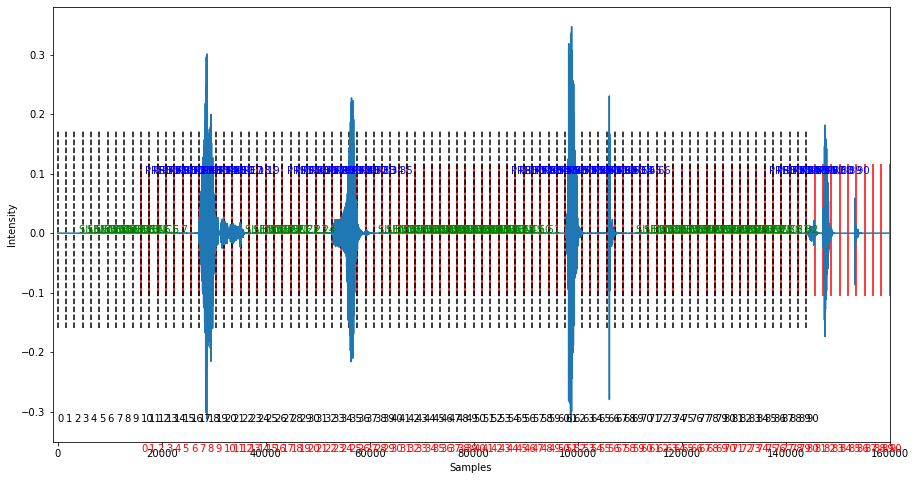

C:\Users\stefano\.conda\envs\gputest\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\stefano\.conda\envs\gputest\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\stefano\.conda\envs\gputest\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this war

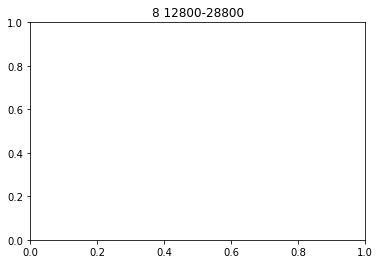

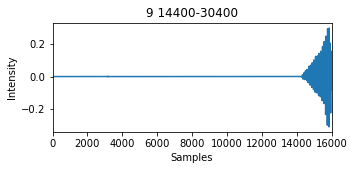

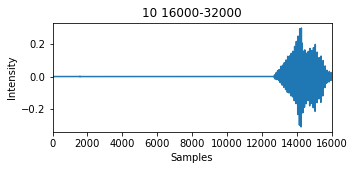

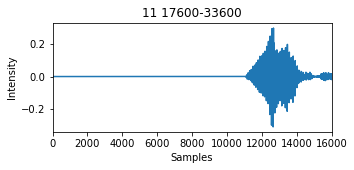

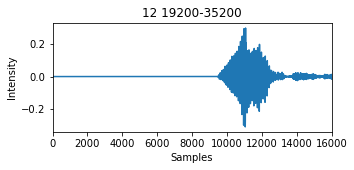

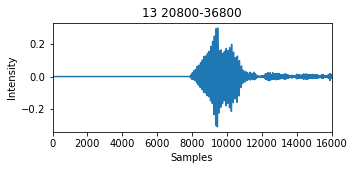

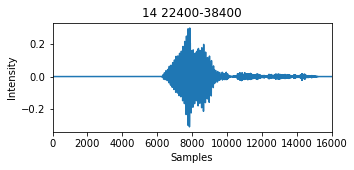

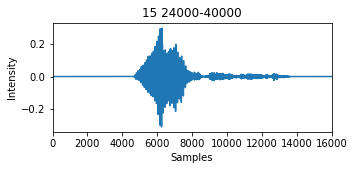

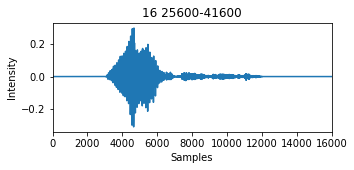

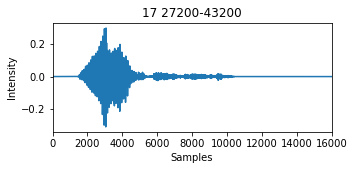

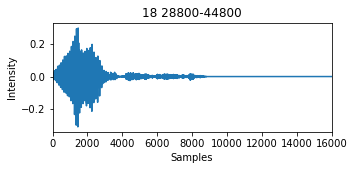

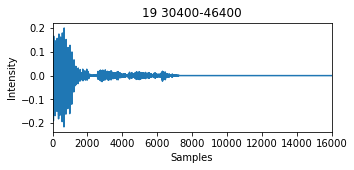

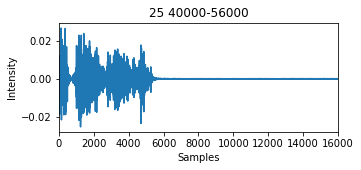

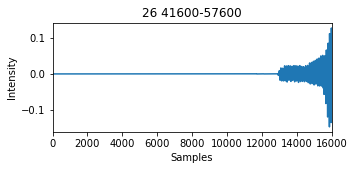

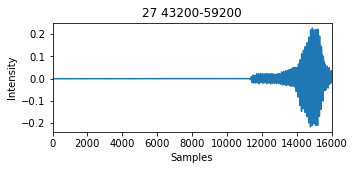

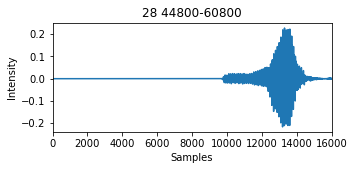

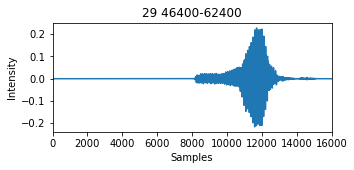

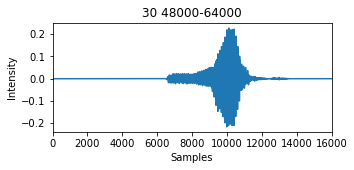

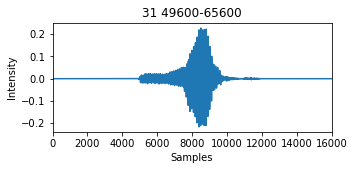

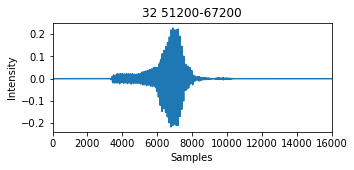

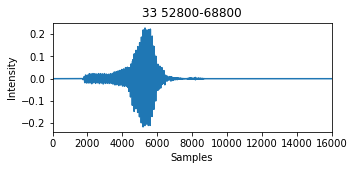

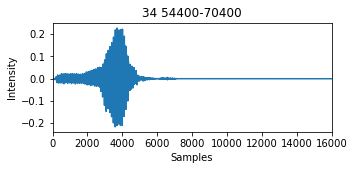

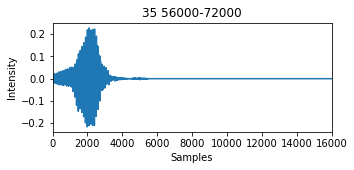

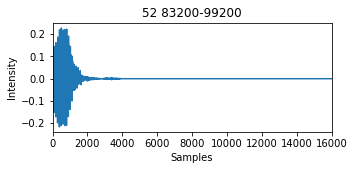

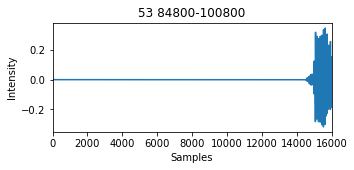

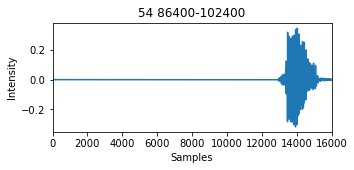

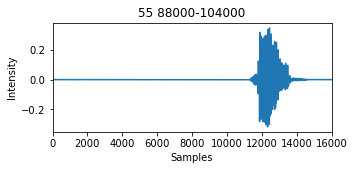

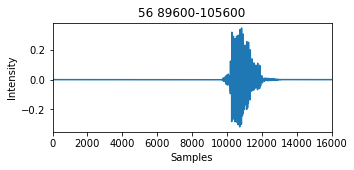

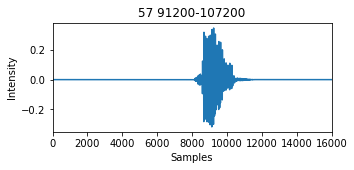

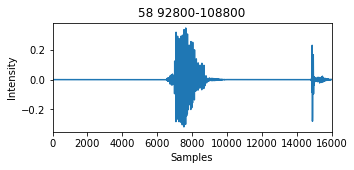

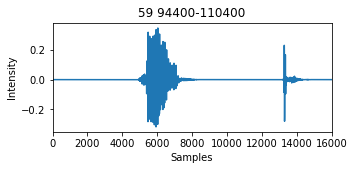

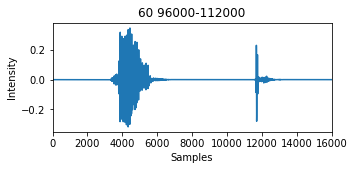

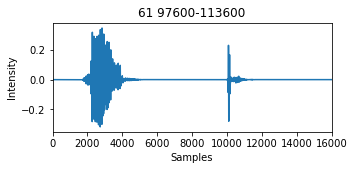

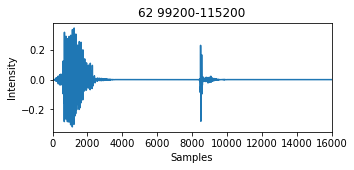

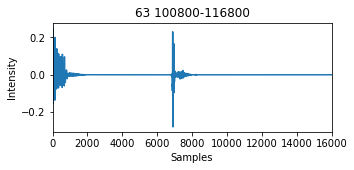

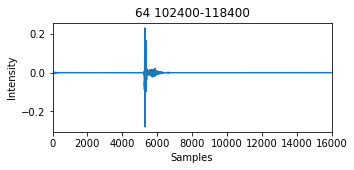

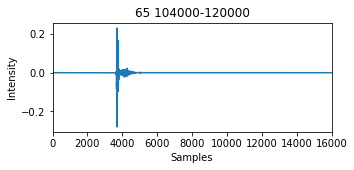

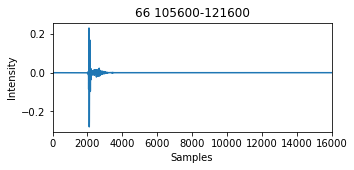

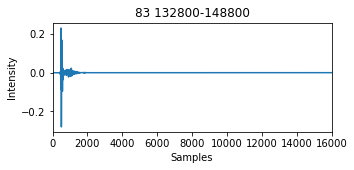

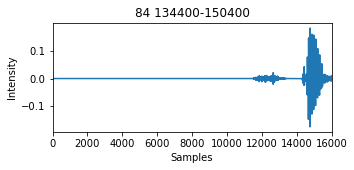

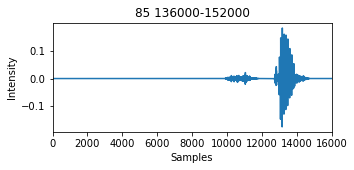

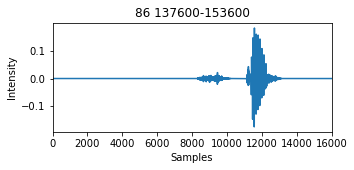

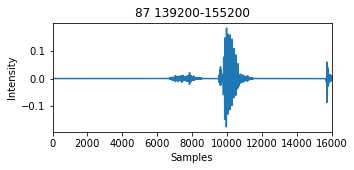

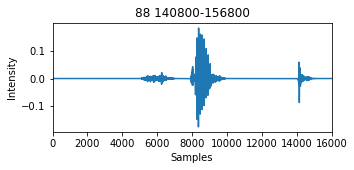

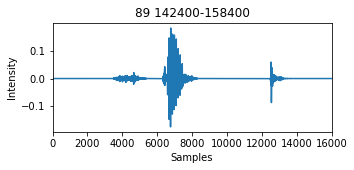

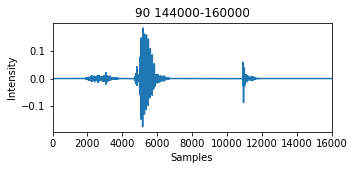

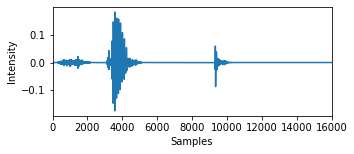

In [50]:
if len(myrec.shape)<2: myrec=myrec[...,np.newaxis] # for the 1 sec audios

ws=10 #windows per second

step=int(sr/ws)
nwin=int((len(myrec)-sr)/step)+1 #number of windows
windows=np.empty((nwin,sr,1))
predictions=np.empty((nwin,1))

print("Number of windows:",nwin)
print("Step:",step)
print(windows.shape)
print(predictions.shape)

#divide in windows
for i in range(nwin):
    start=int(i*step)
    end=int(start+sr)
    windows[i]=myrec[start:end]

    
# Plot
plt.figure(figsize=(15, 8))
plt.plot(myrec)
plt.xlabel("Samples")
plt.ylabel("Intensity")
plt.xlim(-1000, len(myrec))


for i in range(nwin):
    start=int(i*step)
    plt.vlines(start, np.min(myrec)/2, np.max(myrec)/2, colors='k',linestyles='dashed')
    plt.vlines(start+sr, np.min(myrec)/3, np.max(myrec)/3, colors='r')
    plt.text(start, np.min(myrec), i)
    plt.text(start+sr, np.min(myrec)-0.05, i, color='red')
    
    #SILENCE FILTER
    if np.mean(np.abs(windows[i]))<(10**-3):
        predictions[i]=-1 #Silence
        plt.text(start+sr/4, 0, "SILENCE "+str(i), color='green')
        print("Window",i,"Silence",np.mean(np.abs(windows[i])))
    else:
        #preprocessing:
        #e=LoadAndPreprocessDataset.MFCC(windows[i],n_mfcc=40)
        a=windows[i]
        a=a[np.newaxis,...]
        predictions[i]=np.argmax(model.predict(a),1)
        
        p=categories[int(predictions[i])]
        plt.text(start+sr/4, 0.1, "PRED "+str(i), color='blue')
        print("Window",i,p,np.mean(np.abs(windows[i])))

plt.show()



voice=[] #indeces
for i in range(len(predictions)):
    if predictions[i]!=-1:
        voice.append(i)
        plt.title(str(i)+" "+str(int(i*step))+"-"+str(int(i*step)+sr))
        plt.figure(figsize=(5,2))
        plt.plot(windows[i])
        plt.xlabel("Samples")
        plt.ylabel("Intensity")
        plt.xlim(0, len(windows[i]))

plt.show()


### Fusion Rule

In [51]:
#majority
'''
DFA
         -1           any
         ↓ ↑   any   ↓ ↑
    --->(S1)--------->(S2)
          ↑            |
          --------------
                -1
'''
newPredictions=[]

s1=True #true=s1, false=s2
i=0
start=0
while i<len(predictions):
    if s1: #state 1
        if predictions[i]!=-1: #not silence
            start=i
            s1=False
        else: #silence
            newPredictions.append(-1)
        i+=1
    else: #state 2
        if predictions[i]!=-1: #not silence
            pass
        else: #silence
            end=i
            a=predictions[start:end]
            #calculate most common number in the list
            ht={}
            freq=0
            most_freq=-1
            for e in a:
                e=int(e)
                if e in ht:
                    ht[e]+=1
                    if ht[e]>freq:
                        most_freq=e
                        freq=ht[e]
                else: ht[e]=0
            newPredictions=newPredictions+[most_freq]*(end-start)
            #append silence
            newPredictions.append(-1)
            s1=True
        i+=1
#print(newPredictions)

for i in range(len(predictions)):
    print(i,"Read:",predictions[i],newPredictions[i],categories[newPredictions[i]])

0 Read: [-1.] -1 go
1 Read: [-1.] -1 go
2 Read: [-1.] -1 go
3 Read: [-1.] -1 go
4 Read: [-1.] -1 go
5 Read: [-1.] -1 go
6 Read: [-1.] -1 go
7 Read: [-1.] -1 go
8 Read: [4.] 0 yes
9 Read: [0.] 0 yes
10 Read: [0.] 0 yes
11 Read: [0.] 0 yes
12 Read: [0.] 0 yes
13 Read: [0.] 0 yes
14 Read: [0.] 0 yes
15 Read: [0.] 0 yes
16 Read: [0.] 0 yes
17 Read: [0.] 0 yes
18 Read: [0.] 0 yes
19 Read: [2.] 0 yes
20 Read: [-1.] -1 go
21 Read: [-1.] -1 go
22 Read: [-1.] -1 go
23 Read: [-1.] -1 go
24 Read: [-1.] -1 go
25 Read: [4.] 4 left
26 Read: [1.] 4 left
27 Read: [1.] 4 left
28 Read: [1.] 4 left
29 Read: [4.] 4 left
30 Read: [4.] 4 left
31 Read: [4.] 4 left
32 Read: [4.] 4 left
33 Read: [4.] 4 left
34 Read: [4.] 4 left
35 Read: [7.] 4 left
36 Read: [-1.] -1 go
37 Read: [-1.] -1 go
38 Read: [-1.] -1 go
39 Read: [-1.] -1 go
40 Read: [-1.] -1 go
41 Read: [-1.] -1 go
42 Read: [-1.] -1 go
43 Read: [-1.] -1 go
44 Read: [-1.] -1 go
45 Read: [-1.] -1 go
46 Read: [-1.] -1 go
47 Read: [-1.] -1 go
48 Read: [-1.]

IndexError: list index out of range

[-1, 2]
[-1, 2, 4, 4, 4, -1]


In [35]:



print(most_freq)

3
